In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import torch

from gptopt.optim.pdhg import pdhg_method_AB, prox_l1, check_dual_feasible, pdhg_diagonal_scaling
from utils_pdhg import *

In [2]:
np.random.seed(0)
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

# Comparison of methods to solve
$$
\begin{array}{ll}
{\text{minimize}} &  
\langle G_1, Z_1 \rangle + \langle G_2, Z_2 \rangle + \frac{\mu}{2}(\|Z_1\|_F^2 + \|Z_2\|_F^2)  + h(X) \\ 
\text{subject to} & X = Z_1^\top B + A^\top Z_2,
\end{array} 
$$

## PDHG
$$
\begin{aligned}
Y^{t+1} &= \operatorname{prox}_{\rho h^*}(Y^t + \rho 
((2Z_1^t - Z_1^{t-1})^\top B  + A^\top (2Z_2^t - Z_2^{t-1})))\\
\begin{bmatrix}
    Z_1^{t+1} \\ Z_2^{t+1}
\end{bmatrix} &=  \frac{1}{1 + \mu\gamma}\left (\begin{bmatrix}
    Z_1^t \\ Z_2^t
\end{bmatrix} - \gamma \left (
\begin{bmatrix}
    B(Y^{t+1})^\top \\ AY^{t+1}
\end{bmatrix}
+ \begin{bmatrix}
    G_1 \\ G_2
\end{bmatrix} \right ) \right )
\end{aligned}
$$


## FISTA for dual solve

$$
\begin{array}{ll}
{\text{maximize}} &  
-\frac{1}{2\mu}\|\mathcal{A}^*(Y) + G\|_F^2 - h^*(Y)
\end{array}  
$$
recover primal using
$$
Z = -\frac{1}{\mu}(\mathcal{A}^*(Y) + G)
$$

#  $m=n=100$

In [3]:
m = n = 100
A, B, G1, G2, A_np, B_np, G1_np, G2_np, lamb_max = gaussian_data(m, n)
beta = 0.5
mu_reg = max(1e-4 * lamb_max**2, 1e-4)

In [4]:
Z_star_1, Z_star_2, f_star = cvxpy_AB(G1_np, G2_np, A_np, B_np, beta, mu=mu_reg, verbose=True)

(CVXPY) Nov 25 05:47:58 PM: Your problem has 20000 variables, 1 constraints, and 0 parameters.
(CVXPY) Nov 25 05:47:58 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 25 05:47:58 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Nov 25 05:47:58 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Nov 25 05:47:58 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Nov 25 05:47:58 PM: Compiling problem (target solver=CLARABEL).
(CVXPY) Nov 25 05:47:58 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> CLARABEL
(CVXPY) Nov 25 05:47:58 PM: Applying reduction Dcp2Cone
(CVXPY) Nov 25 05:47:58 PM: Applying reduction CvxAttr2Constr
(CVXPY) Nov 25 05:47:58 PM: Applying reduction ConeMatrixStuffing


                                     CVXPY                                     
                                     v1.7.3                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Nov 25 05:47:59 PM: Applying reduction CLARABEL
(CVXPY) Nov 25 05:48:00 PM: Finished problem compilation (took 2.263e+00 seconds).
(CVXPY) Nov 25 05:48:00 PM: Invoking solver CLARABEL  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
-------------------------------------------------------------
           Clarabel.rs v0.11.1  -  Clever Acronym                

                   (c) Paul Goulart                          
                University of Oxford, 2022                   
-------------------------------------------------------------

problem:
  variables     = 30001
  constraints   = 30001
  nnz(P)        = 20000
  nnz(A)        = 4040001
  cones (total) = 1
    : Nonnegative = 1,  numel = 30001

settings:
  linear algebra: direct / faer, precision: 64 bit (32 threads)
  max iter = 200, time limit = Inf,  max step = 0.990
  tol_feas = 1.0e-8, tol_gap_abs = 1.0e-8, tol_gap_rel = 1.0e-8,
  static reg : on, ϵ1 = 1.0e-8, ϵ2 = 4.9e-32
  dynamic reg: on, ϵ = 1.0e-13, δ = 2.0e

(CVXPY) Nov 25 05:53:12 PM: Problem status: optimal
(CVXPY) Nov 25 05:53:12 PM: Optimal value: -3.922e+03
(CVXPY) Nov 25 05:53:13 PM: Compilation took 2.263e+00 seconds
(CVXPY) Nov 25 05:53:13 PM: Solver (including time spent in interface) took 3.125e+02 seconds


 13  -3.9218e+03  -3.9218e+03  1.05e-09  4.00e-12  1.06e-10  4.24e-12  1.34e-10  9.90e-01  
---------------------------------------------------------------------------------------------
Terminated with status = Solved
solve time = 312.15619421s
-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


In [5]:
# Torch prox for h* (uses prox_l1 from pdhg.py)
prox_h_conj = lambda y, rho, R: prox_l1(y, rho * beta, R=R)
h_conj = lambda y: beta * torch.abs(y).sum()

In [6]:
func_obj = lambda Z1, Z2: (torch.trace(G1.T @ Z1) + torch.trace(G2.T @ Z2) \
                          + (mu_reg / 2) * ((Z1).pow(2).sum() + Z2.pow(2).sum())).item()  
func_constr_viol = lambda Z1, Z2: max(torch.max(torch.abs(Z1.T @ B + A.T @ Z2)).item() - beta, 0) / beta

In [ ]:
print(
    f"{f_star=}, "
    f"{func_obj(torch.from_numpy(Z_star_1).to(G1), torch.from_numpy(Z_star_2).to(G2))}, "
    f"\ncvxpy constraint violation: "
    f"{func_constr_viol(torch.from_numpy(Z_star_1).to(G1), torch.from_numpy(Z_star_2).to(G2))}"
)

f_star=np.float64(-3921.8439997356973), -3921.843994140625, 
cvxpy constraint violation: 4.76837158203125e-07


In [13]:
residuals = compare_methods(prox_h_conj, h_conj, lamb_max, A, B, G1, G2, beta, mu_reg, f_star=f_star, stopping=False, max_iter=10000)

lamb_max=140.06734324998592
obj (diag scaling):  -3921.84521484375 
constraint viol (diag scaling):  7.271766662597656e-05
lamb_max=140.06734324998592
obj (vanilla):  -3921.826171875 
constraint viol (vanilla):  5.137920379638672e-05
lamb_max=140.06734324998592
obj (vanilla):  -3921.846435546875 
constraint viol (vanilla):  0.00021195411682128906
obj (fista):  -3920.80908203125 
constraint viol (fista):  0.0037267208099365234


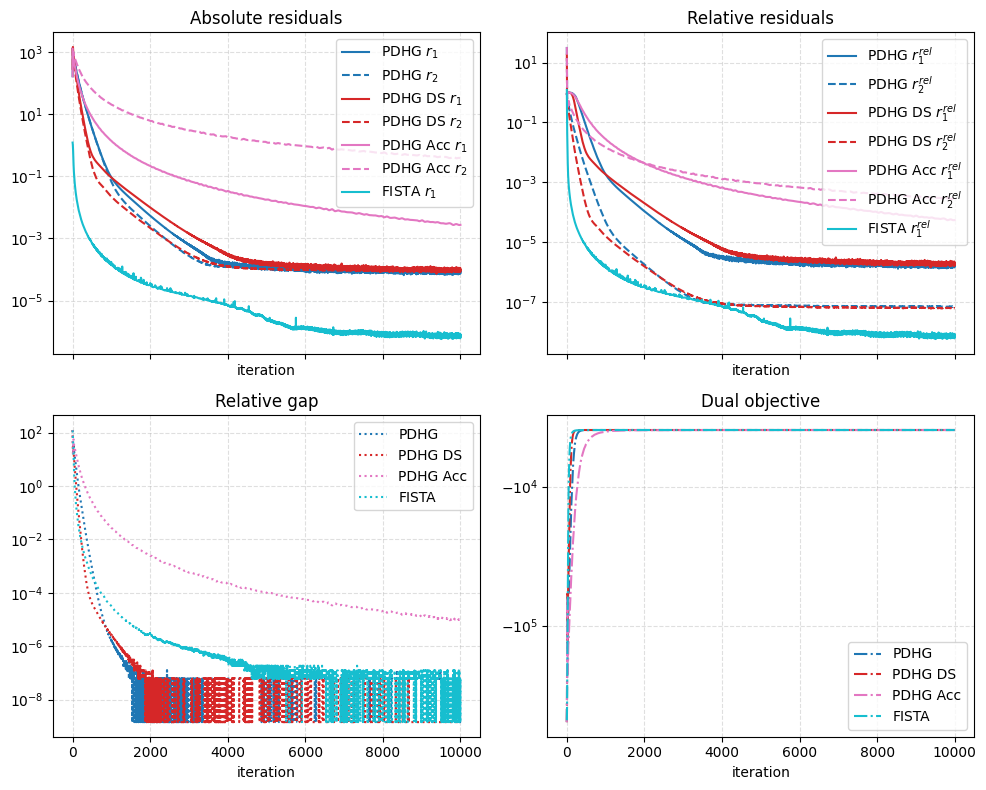

In [14]:
plot_residuals_compare(residuals, dpi=100)

#  $m=n=1000$

In [15]:
m = n = 1000
A, B, G1, G2, A_np, B_np, G1_np, G2_np, lamb_max = gaussian_data(m, n)
beta = 0.5
mu_reg = max(1e-6 * lamb_max**2, 1e-6)

In [16]:
residuals = compare_methods(prox_h_conj, h_conj, lamb_max, A, B, G1, G2, beta, mu_reg, f_star=None, stopping=False, max_iter=1000)

lamb_max=1413.5468841316172
obj (diag scaling):  -378692.59375 
constraint viol (diag scaling):  47.81010818481445
lamb_max=1413.5468841316172
obj (vanilla):  -319554.09375 
constraint viol (vanilla):  77.17556762695312
lamb_max=1413.5468841316172
obj (vanilla):  -323781.90625 
constraint viol (vanilla):  59.46123504638672
obj (fista):  -350930.5625 
constraint viol (fista):  35.21335983276367


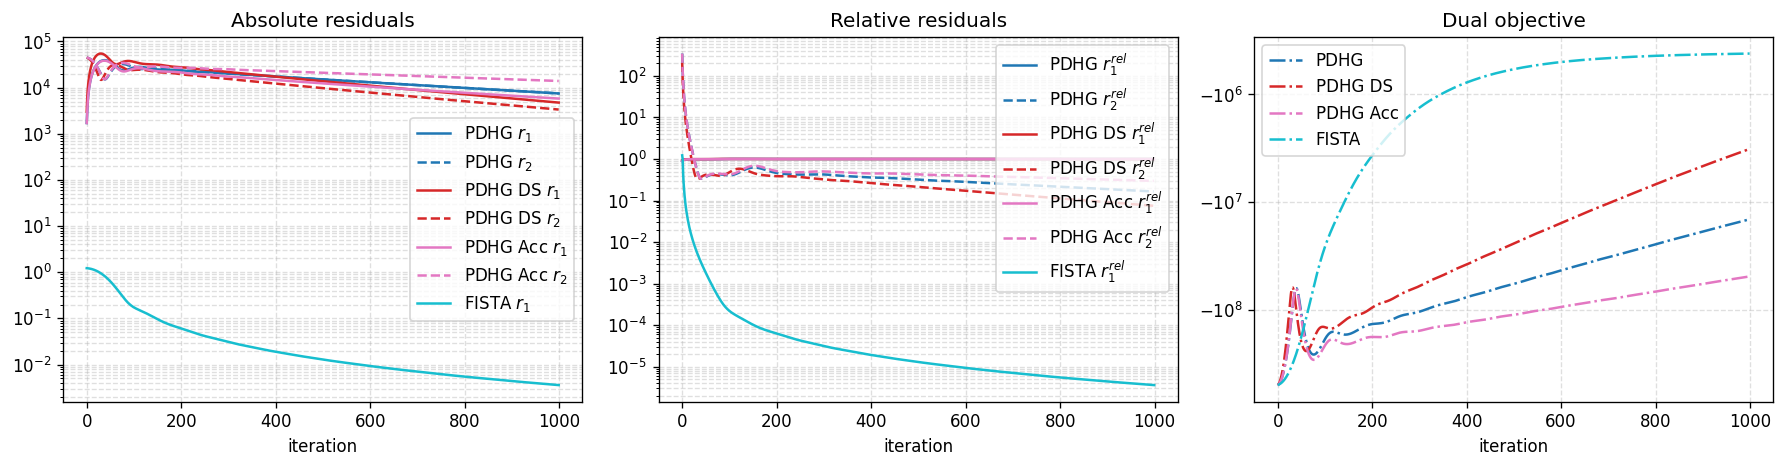

In [17]:
plot_residuals_compare(residuals)

#  $m=n=1000$

In [18]:
m = n = 1000
A, B, G1, G2, A_np, B_np, G1_np, G2_np, lamb_max = gaussian_data(m, n)
beta = 0.5
mu_reg = max(1e-6 * lamb_max**2, 1e-4)

In [19]:
residuals = compare_methods(prox_h_conj, h_conj, lamb_max, A, B, G1, G2, beta, mu_reg, f_star=None, max_iter=1000, stopping=False)

lamb_max=1413.7809250851524
obj (diag scaling):  -367078.25 
constraint viol (diag scaling):  44.29145050048828
lamb_max=1413.7809250851524
obj (vanilla):  -330934.78125 
constraint viol (vanilla):  71.13692474365234
lamb_max=1413.7809250851524
obj (vanilla):  -332946.875 
constraint viol (vanilla):  56.25718688964844
obj (fista):  -360730.53125 
constraint viol (fista):  34.2539176940918


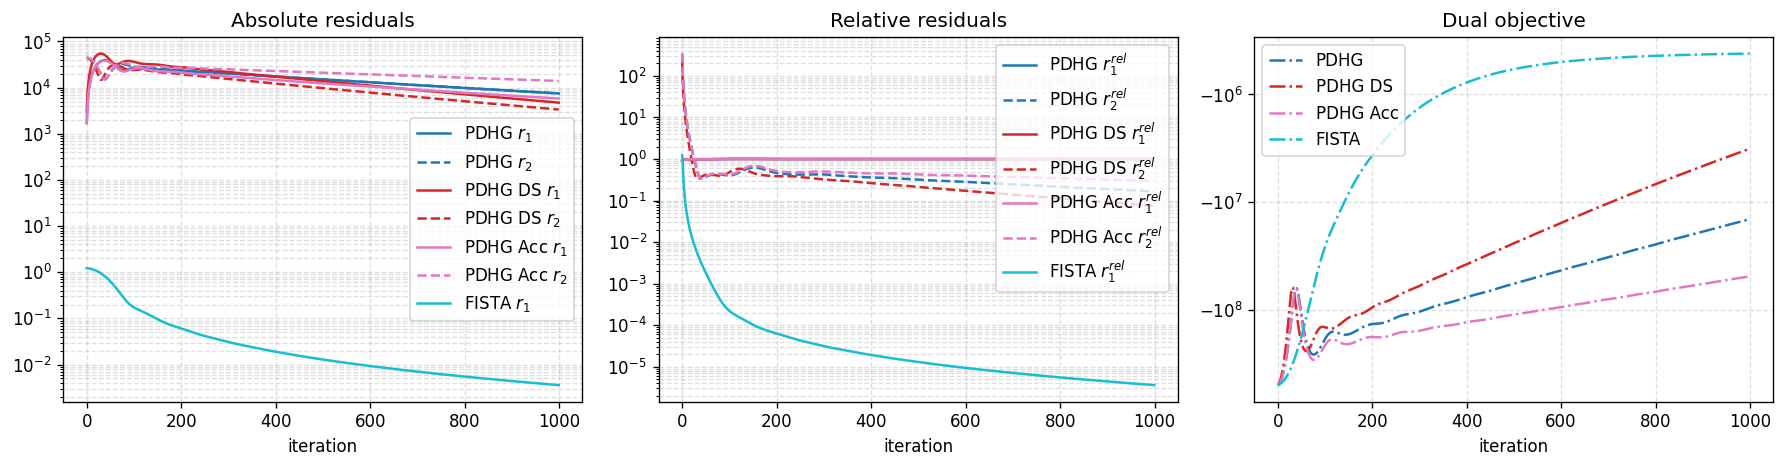

In [20]:
plot_residuals_compare(residuals)